In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [12]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [13]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_win/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [14]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt"

In [15]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [16]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [17]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

iter 1: 0.274207
iter 2: 0.181481
iter 3: 0.133261
iter 4: 0.107309
iter 5: 0.0757077
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt


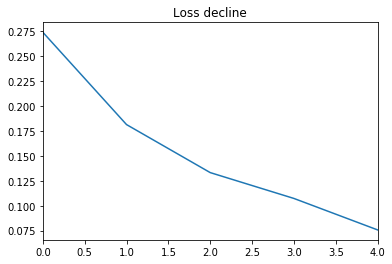

In [18]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [19]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Finished


In [12]:
# the threshold leads to best f1 sore
def evaluate(threshold):
    beta = 0.5
    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
    fp = len(abnormal_score)-tp
    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
    tn = len(normal_score)- fn
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta


upper = np.median(np.array(abnormal_score))
lower = np.median(np.array(normal_score)) 
scala = 20
delta = (upper-lower) / scala
candidate = lower
threshold = 0
result = 0

for _ in range(scala):
    r = evaluate(candidate)
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

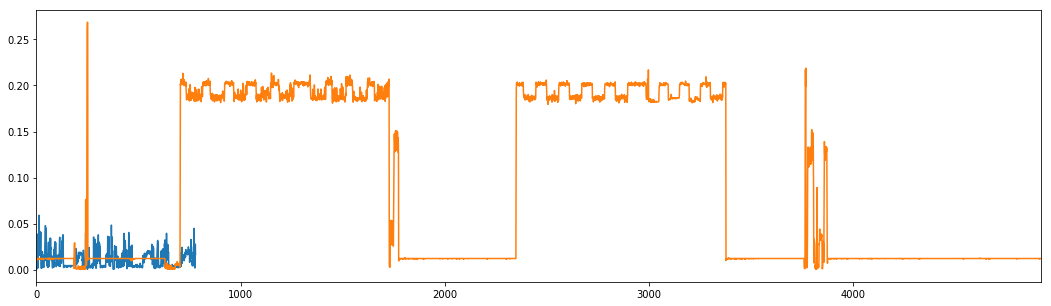

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

In [14]:
beta = 0.1
tp = np.array(abnormal_score)[abnormal_score>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[normal_score>threshold].size
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9644434073659839

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v2.ckpt
Model restored.
Initialized
Predict result :


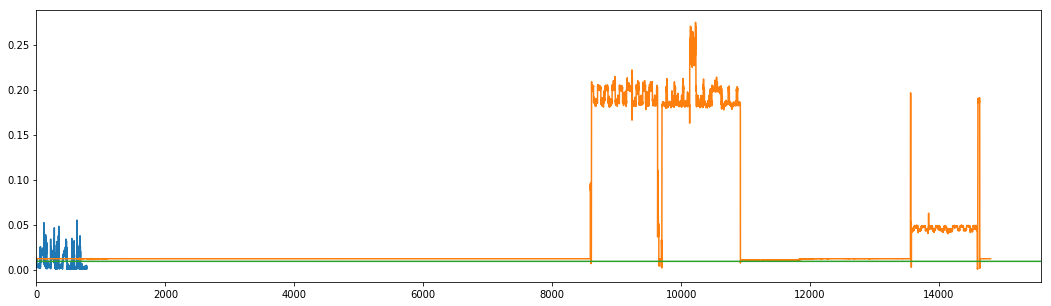

In [15]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9948409170505672

In [17]:
print(tp,fp,tn,fn,P,R)

14771 29 513 267 0.9980405405405406 0.9822449793855565


In [18]:
tp/fp

509.3448275862069